In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


In [2]:
df = pd.read_csv(r'./archive/long_data_.csv')
df = df.set_index('Dates')
df.index = pd.to_datetime(df.index)


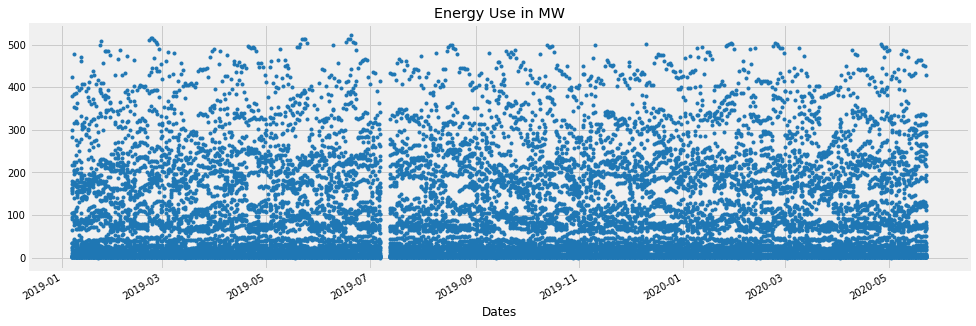

In [3]:
df['Usage'].plot(style='.',
                 figsize=(15, 5),
                 color=color_pal[0],
                 title='Energy Use in MW')
plt.show()


In [4]:
df


,States,Regions,latitude,longitude,Usage
Dates,,,,,
2019-02-01,Punjab,NR,31.519974,75.980003,119.9
2019-02-01,Haryana,NR,28.450006,77.019991,130.3
2019-02-01,Rajasthan,NR,26.449999,74.639981,234.1
2019-02-01,Delhi,NR,28.669993,77.230004,85.8
2019-02-01,UP,NR,27.599981,78.050006,313.9
...,...,...,...,...,...
2020-05-12,Manipur,NER,24.799971,93.950017,2.5
2020-05-12,Meghalaya,NER,25.570492,91.880014,5.8
2020-05-12,Mizoram,NER,23.710399,92.720015,1.6


In [5]:
label_encoder = OrdinalEncoder()
df[['States', 'Regions']] = label_encoder.fit_transform(
    df[['States', 'Regions']])


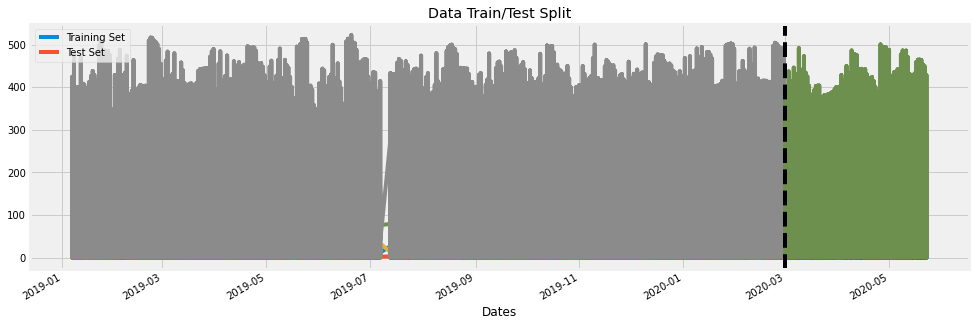

In [6]:
train = df.loc[df.index < '03-01-2020']
test = df.loc[df.index >= '03-01-2020']
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('03-01-2020', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


In [7]:
state_mapper = dict(zip(label_encoder.__dict__['categories_'][0], range(
    len(label_encoder.__dict__['categories_'][0]))))
region_mapper = dict(zip(label_encoder.__dict__['categories_'][1], range(
    len(label_encoder.__dict__['categories_'][1]))))


In [8]:
region_mapper


{'ER': 0, 'NER': 1, 'NR': 2, 'SR': 3, 'WR': 4}

In [9]:
def state_inverse_trandform(x: int):
    return list(state_mapper.keys())[list(state_mapper.values()).index(x)]


def region_inverse_trandform(x: int):
    return list(region_mapper.keys())[list(region_mapper.values()).index(x)]


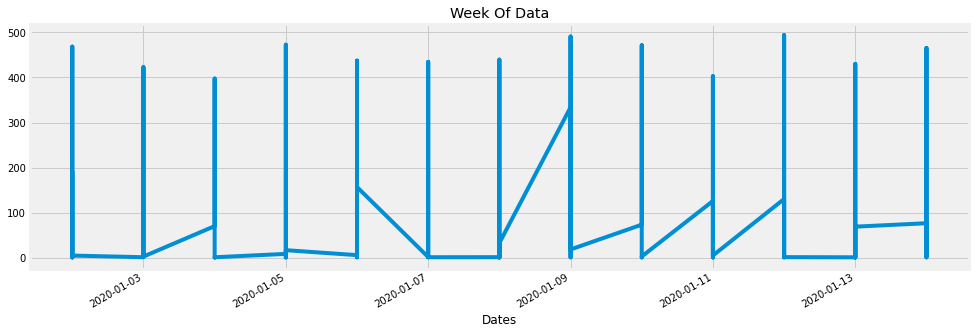

In [10]:
df['Usage'].loc[(df.index > '01-01-2020') & (df.index < '01-15-2020')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()


In [11]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df


df = create_features(df)


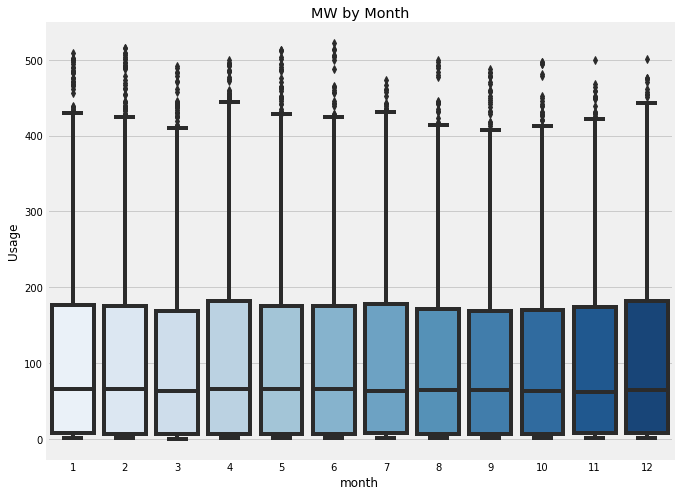

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Usage', palette='Blues')
ax.set_title('MW by Month')
plt.show()


In [13]:
df


,States,Regions,latitude,longitude,Usage,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Dates,,,,,,,,,,,,
2019-02-01,24.0,2.0,31.519974,75.980003,119.9,4,1,2,2019,32,1,5
2019-02-01,11.0,2.0,28.450006,77.019991,130.3,4,1,2,2019,32,1,5
2019-02-01,25.0,2.0,26.449999,74.639981,234.1,4,1,2,2019,32,1,5
2019-02-01,7.0,2.0,28.669993,77.230004,85.8,4,1,2,2019,32,1,5
2019-02-01,30.0,2.0,27.599981,78.050006,313.9,4,1,2,2019,32,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-12,18.0,1.0,24.799971,93.950017,2.5,1,2,5,2020,133,12,20
2020-05-12,19.0,1.0,25.570492,91.880014,5.8,1,2,5,2020,133,12,20
2020-05-12,20.0,1.0,23.710399,92.720015,1.6,1,2,5,2020,133,12,20


In [14]:
df['Usage'].describe()


count    16599.000000
mean       103.001862
std        116.044056
min          0.300000
25%          6.700000
50%         64.400000
75%        173.900000
max        522.100000
Name: Usage, dtype: float64

In [15]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter',
            'month', 'year', 'States', 'Regions', ]
TARGET = 'Usage'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


In [16]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16599 entries, 2019-02-01 to 2020-05-12
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   States      16599 non-null  float64
 1   Regions     16599 non-null  float64
 2   latitude    16599 non-null  float64
 3   longitude   16599 non-null  float64
 4   Usage       16599 non-null  float64
 5   dayofweek   16599 non-null  int64  
 6   quarter     16599 non-null  int64  
 7   month       16599 non-null  int64  
 8   year        16599 non-null  int64  
 9   dayofyear   16599 non-null  int64  
 10  dayofmonth  16599 non-null  int64  
 11  weekofyear  16599 non-null  UInt32 
dtypes: UInt32(1), float64(5), int64(6)
memory usage: 1.6 MB


In [29]:
reg = xgb.XGBRegressor(booster='gbtree',
                       n_estimators=10000000,
                       early_stopping_rounds=10000,
                       max_depth=1,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=20000)


[0]	validation_0-rmse:154.25432	validation_1-rmse:152.47789
[20000]	validation_0-rmse:45.21349	validation_1-rmse:45.06933
[40000]	validation_0-rmse:33.51715	validation_1-rmse:33.78798
[60000]	validation_0-rmse:28.06789	validation_1-rmse:28.70990
[80000]	validation_0-rmse:25.66876	validation_1-rmse:26.58476
[100000]	validation_0-rmse:24.58542	validation_1-rmse:25.75446
[120000]	validation_0-rmse:24.04104	validation_1-rmse:25.48439
[140000]	validation_0-rmse:23.72453	validation_1-rmse:25.45002
[148833]	validation_0-rmse:23.62086	validation_1-rmse:25.48558


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=10000, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=1, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10000000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [59]:
X_train

,dayofyear,dayofweek,quarter,month,year,States,Regions
Dates,,,,,,,
2019-02-01,32,4,1,2,2019,24.0,2.0
2019-02-01,32,4,1,2,2019,11.0,2.0
2019-02-01,32,4,1,2,2019,25.0,2.0
2019-02-01,32,4,1,2,2019,7.0,2.0
2019-02-01,32,4,1,2,2019,30.0,2.0
...,...,...,...,...,...,...,...
2020-02-12,43,2,1,2,2020,18.0,1.0
2020-02-12,43,2,1,2,2020,19.0,1.0
2020-02-12,43,2,1,2,2020,20.0,1.0


In [111]:
cols = ['dayofyear', 'dayofweek', 'quarter',
        'month', 'year', 'States', 'Regions']


In [121]:
zipped = list(zip([1], [1], [2], [5], [2020], [1], [1]))
df_ = pd.DataFrame(zipped, columns=cols)


In [122]:
reg.predict(df_)[0]


2.1175385

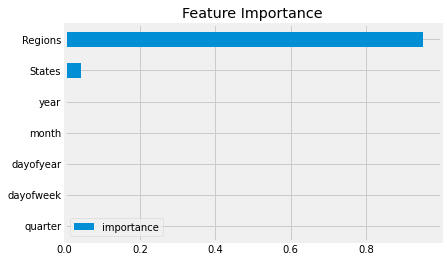

In [18]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()


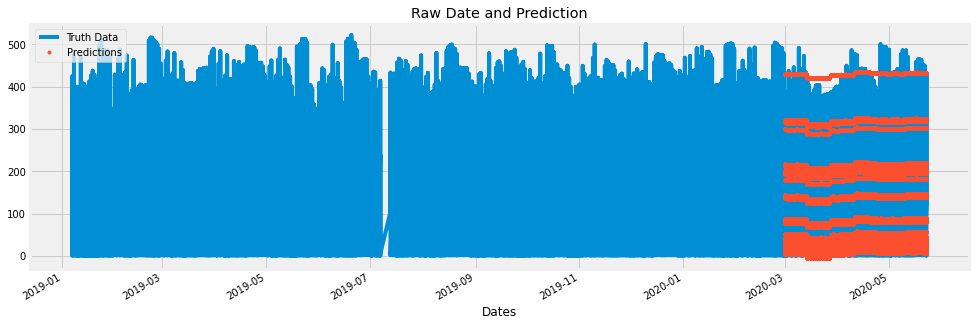

In [19]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left',
              left_index=True, right_index=True)
ax = df[['Usage']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Date and Prediction')
plt.show()


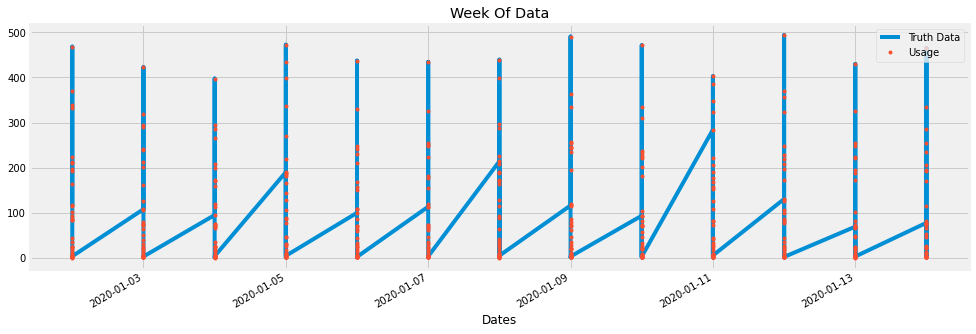

In [20]:

ax = df.loc[(df.index > '01-01-2020') & (df.index < '01-15-2020')]['Usage'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '01-01-2020') & (df.index < '01-15-2020')]['Usage'] \
    .plot(style='.')
plt.legend(['Truth Data', 'Usage'])
plt.show()


In [31]:
score = np.sqrt(mean_squared_error(test['Usage'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.3f}')
print(f"{mean_absolute_error(test['Usage'], test['prediction']):.03f}")


RMSE Score on Test set: 25.446
16.127


In [22]:
reg.score(X_test, y_test)


0.9510173640019125

<AxesSubplot:xlabel='date'>

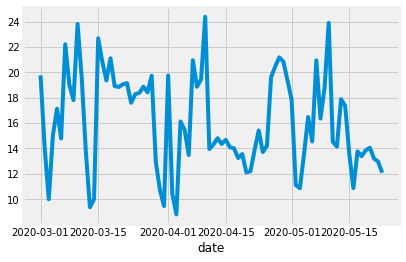

In [23]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
errors = test.groupby(['date'])['error'].mean().sort_values()
errors.plot()


In [27]:
# # export the model
# import pickle
# with open("time_series_pickle", "wb") as f:
#     pickle.dump(reg, f)


In [116]:
from datetime import date


In [123]:
df_['date'] = [date(year=2020, month=5, day=1)]


In [124]:
df_ = df_.set_index('date')
df_.index = pd.to_datetime(df_.index)


In [125]:
df_


,dayofyear,dayofweek,quarter,month,year,States,Regions
date,,,,,,,
2020-05-01,1,1,2,5,2020,1,1


In [126]:
reg.predict(df_)


array([2.1175385], dtype=float32)